# Function fitting with neural networks

The goal of this notebook is to learn how to train neural networks to fit scalar functions of a single scalar variable. Our choice of target function is the gaussian-like

$f(x) = e^{-x^2/4}$.

## Previous steps

First we have to download the `torch` library, this is, Python's machine learning library of our choice. The official way to do this is via the website https://pytorch.org/get-started/locally/. 

In Python there are other libraries we can use to achieve the same results, such as `tensorflow` (https://www.tensorflow.org/) or `JAX` (https://jax.readthedocs.io/en/latest/notebooks/quickstart.html). Also, simple algorithms like the one we aim to code can be easily designed with pen and paper and then directly implemented in simple Python.

## Imports
We import the necessary libraries and modules.

In [1]:
import torch # Python's machine learning library of choice
from torch import nn
import numpy as np 
import matplotlib.pyplot as plt # for plotting

## Parameters, Hyperparameter
We define some parameters and hyperparameters. Perhaps the oddest parameter is :

`device` &rarr; the hardware device where our model will run. We can choose between CPU and GPU (graphics card), or if we work for Google, TPU. In general GPUs are much faster than CPUs for AI workloads, but for smaller models like ours one finds rather the opposite (https://www.run.ai/guides/multi-gpu/cpu-vs-gpu#machine-and-deep-learning).

**Hyperparameter vs Parameter**: there is no unique definition, but we generally say parameters to refer to the *weights* and *bias* of the network, i.e., what is learnt during the training process. In this document we will refer to the set of trainable parameters by $\theta$. The hyperparameters are the choices we make before the training starts, and although they remain constant during the training they have an effect on the model's performance. The activation function, the optimizer, the learning rate and the loss function are examples of hyperparameters that we always have to set. 

In [2]:
# Hardware
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Network hyperparameters
Nin = 1 # number of inputs
Nhid = 4 # number of hidden nodes/neurons
Nout = 1 # number of outputs

# Train set
n_samples = 100 # size of the train set
train_a = -3 # left endpoint
train_b = 3 # right endpoint
train_set = torch.linspace(train_a, train_b, n_samples).view(n_samples, -1).to(device)

# Hyperparameters
epochs = 500 # number of iterations
lr = 0.01 # learning rate  

# Others
seed = 1 # seed for random number generation
torch.manual_seed(seed) 
target_function = lambda x : torch.exp(-x**2 / 4) # target function

# Network parameters
W1 = (torch.rand(Nhid, Nin)*(-1.)).to(device) 
B = (torch.rand(Nhid)*2. - 1.).to(device) 
W2 = torch.rand(Nout, Nhid).to(device)

## The neural network
We now code the neural network. In PyTorch every neural network must be created as a "child" of the `nn.Module` class (tutorial on Python classes: https://realpython.com/python3-object-oriented-programming/). Inside the `__init__` method we define the layers. In our case we will have a single hidden layer and therefore a single activation function and two affine transformations at each "side" of the hidden layer. Inside the `with torch.no_grad()` block we define the initial parameters of the network. 

Finally, inside the `forward` method we set the connections between the different elements of the network, or in other words, we set the network architecture.

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self, W1, B, W2):
        super(NeuralNetwork, self).__init__()
        
        # We set the linear transformations and the activation function
        self.lc1 = nn.Linear(Nin, Nhid, bias=True) # shape = (Nhid, Nin)
        self.actfun = nn.Sigmoid() # activation function
        self.lc2 = nn.Linear(Nhid, Nout, bias=False) # shape = (Nout, Nhid)
        
        # We set the parameters
        with torch.no_grad():
            self.lc1.weight = nn.Parameter(W1)
            self.lc1.bias = nn.Parameter(B)
            self.lc2.weight = nn.Parameter(W2)
   
    # We set the architecture
    def forward(self, x): 
        o = self.lc2(self.actfun(self.lc1(x)))
        return o

We can graphically represent the network above as follows:

<img src="assets/simple_ann.png\"
         alt="Markdown Monster icon"
         style="float: center;"
         width="500"
         height="400"/>

We can also see the network architecture using the following syntax:

In [4]:
net = NeuralNetwork(W1, B, W2).to(device) # we make an instance of the network class
print('NN architecture: \n', net)

NN architecture: 
 NeuralNetwork(
  (lc1): Linear(in_features=1, out_features=4, bias=True)
  (actfun): Sigmoid()
  (lc2): Linear(in_features=4, out_features=1, bias=False)
)


In order to see the initial trainable parameter values we can do the following:

In [5]:
print("Layers and parameters:\n")
for name, param in net.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:50]} \n")

Layers and parameters:

Layer: lc1.weight | Size: torch.Size([4, 1]) | Values : tensor([[-0.7576],
        [-0.2793],
        [-0.4031],
        [-0.7347]], grad_fn=<SliceBackward0>) 

Layer: lc1.bias | Size: torch.Size([4]) | Values : tensor([-0.9414,  0.5997, -0.2057,  0.5087], grad_fn=<SliceBackward0>) 

Layer: lc2.weight | Size: torch.Size([1, 4]) | Values : tensor([[0.5695, 0.4388, 0.6387, 0.5247]], grad_fn=<SliceBackward0>) 



## The optimizer
We choose RMSprop as our optimizer, which in our case will update the parameters according to:

$$ g_t \longleftarrow \nabla_{\theta}\mathcal{L_t(\theta_{t-1})},$$

$$ v_t \longleftarrow \alpha v_{t-1}+(1-\alpha)(g_t)^2,$$

$$\theta_t \longleftarrow \theta_{t-1}-\gamma\frac{g_t}{\sqrt{v_t+\epsilon}},$$

where $\mathcal{L}$ is the *loss function* (explained below), $\alpha$ is a constant of the optimizer (another hyperparameter), $\gamma$ is the learning rate and $\epsilon$ is a constant added for the sake of numerical stability. The general formula for RMSprop is slightly more involved, in the sense that it admits further hyperparameters such as *momentum*, *weight decay* and so forth (https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html). In practice the above formulas are already implemented in the PyTorch engine, inside the `torch.optim` class, and thus we can set the optimizer with a single line of code:

In [7]:
optimizer = torch.optim.RMSprop(params=net.parameters(), lr=lr)

## The loss function
It is a scalar function used to evaluate how our model is performing at a given iteration/epoch. Given that we want to fit our network to a known function, we can use some sort of distance between functions to decide how good the network prediction is. The typical choice in these situations is the *Mean Squared Error* or MSE:

$$ \mathcal{L} = \sum_{i=1}^N \left(\hat{y}_i-y_i\right)^2, $$

where $\hat{y}_i$ is the i-th train set label and $y_i$ is the network prediction for the i-th train set point. This function is built-in in the PyTorch engine, so we do not have to code it ourselves. We can summon it with the syntax below:

In [6]:
loss_fn = nn.MSELoss() # Mean Squared Error

## Plotting
Every certain number of epochs we will plot the network prediction agains the exact values. To this end we define the following function:

In [8]:
def pic_creator(t, train_set, pred, target, loss_list):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    plt.subplots_adjust(wspace=0.4)

    # Functions
    ax0 = ax[0]
    fig.suptitle(f'Epoch {t+1}', fontsize=20)
    ax0.set_title(f'Functions', fontsize=15)
    ax0.set_xlabel('x', fontsize=15)
    ax0.set_ylabel('f(x)', fontsize=15)
    ax0.plot(train_set.cpu().numpy(), pred.cpu().detach().numpy(), label='ANN')
    ax0.plot(train_set.cpu().numpy(), target.cpu().numpy(), label='f(x)')
    ax0.legend()

    # Loss
    ax1 = ax[1]
    ax1.set_title('Loss. Current value: {:.4f}'.format(loss_list[-1]))
    ax1.set_xlabel('Epoch', fontsize=15)
    ax1.set_ylabel('Loss', fontsize=15)
    ax1.plot([i for i in range(t+1)], loss_list, label='MSE')
    ax1.legend()

    plt.show()  

## Training the newtork
The training process consists of a `for` loop which is executed during a certain number of iterations that we have define inside the variable `epochs`. The key lines of code are: 

`optimizer.zero_grad()` &rarr; sets all gradients to zero so as not to accumulate their values from the previous iteration. 

`loss.backward()` &rarr; computes the gradient of the loss w.r.t. the parameters passed to the optimizer using the *backpropagation* algorithm. These gradient components are stored in the `.grad` attribute of the tensors with the `requires_grad` flag set to `True`.

`optimizer.step()` &rarr; updates the parameters $\theta$ with the information computed in the previous step.

**Important**: the input to the networ, defined in the variable `train_set`, must have shape `[n_samples, feature_dimensions]`. This is so as not to pass all the different input points of the training set to the network in a loop. Since both the forward and backward passes for a given point are not affected by any other point in the training set in the same iteration, we can perform all `n_samples` passes **in parallel**. In fact, PyTorch expects that the first dimension of the input tensor refers to the size of the training set or *batch size*, and it will automatically parallelize the process in our hardware.

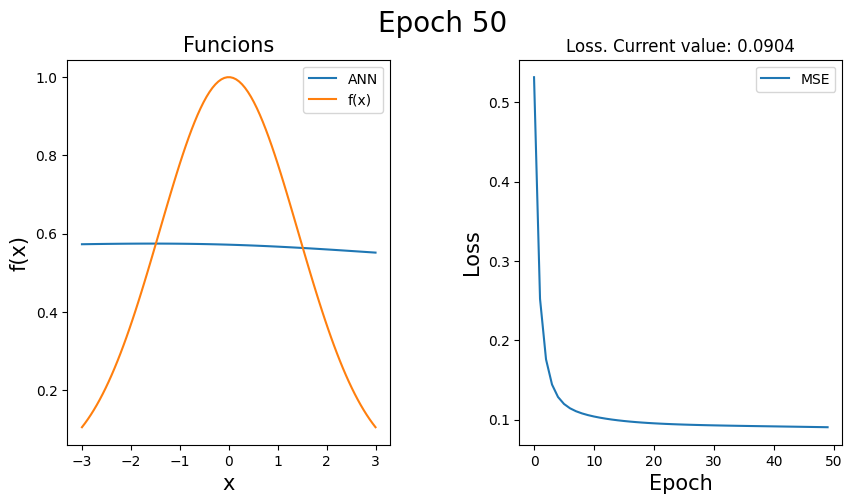

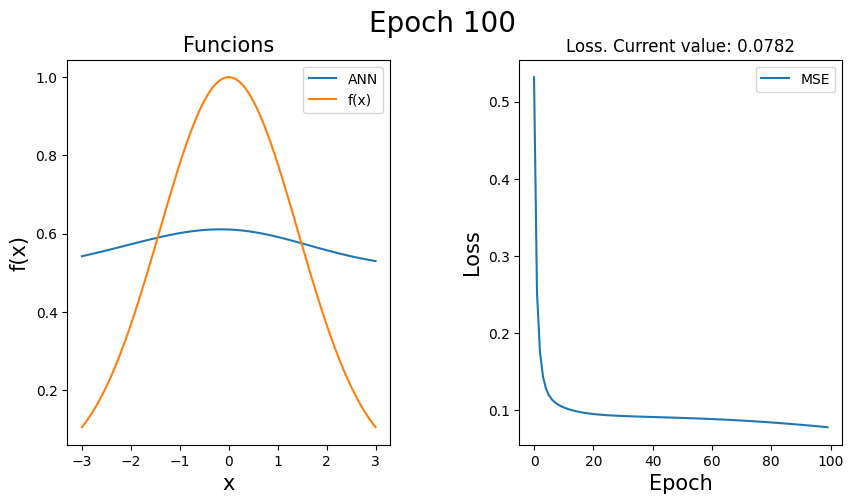

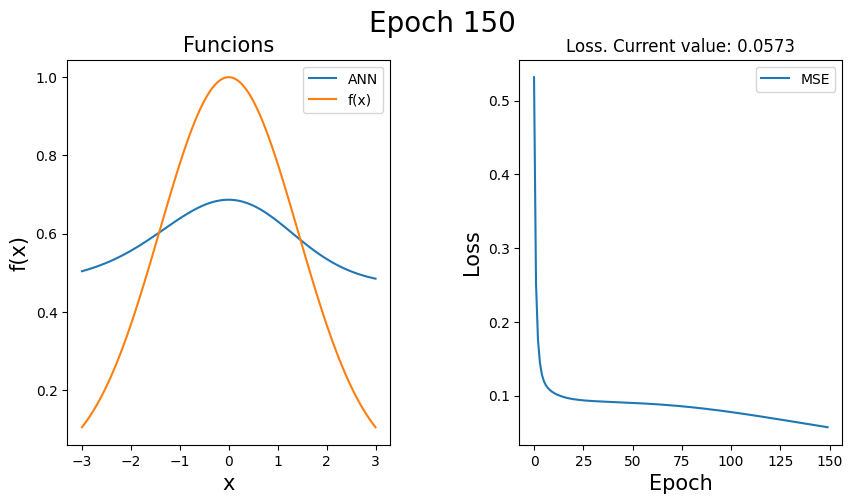

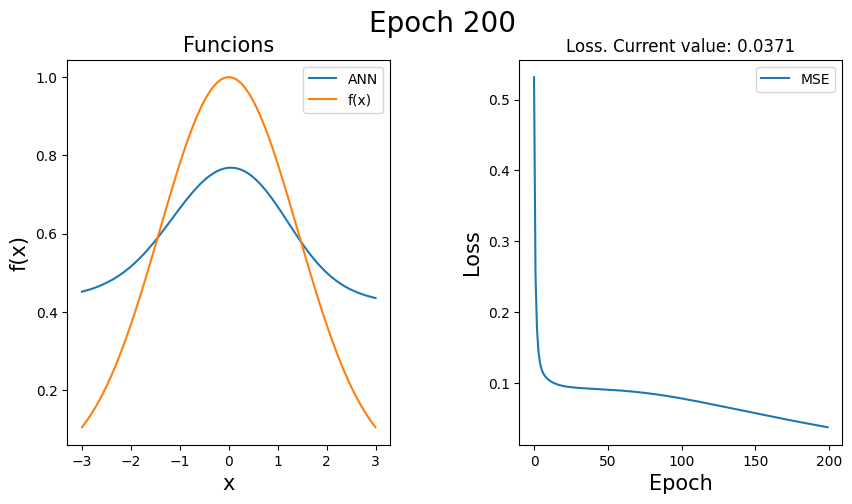

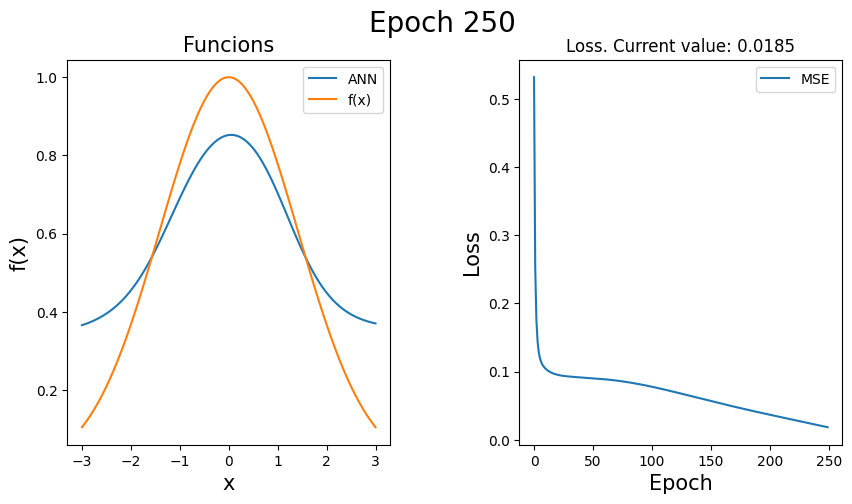

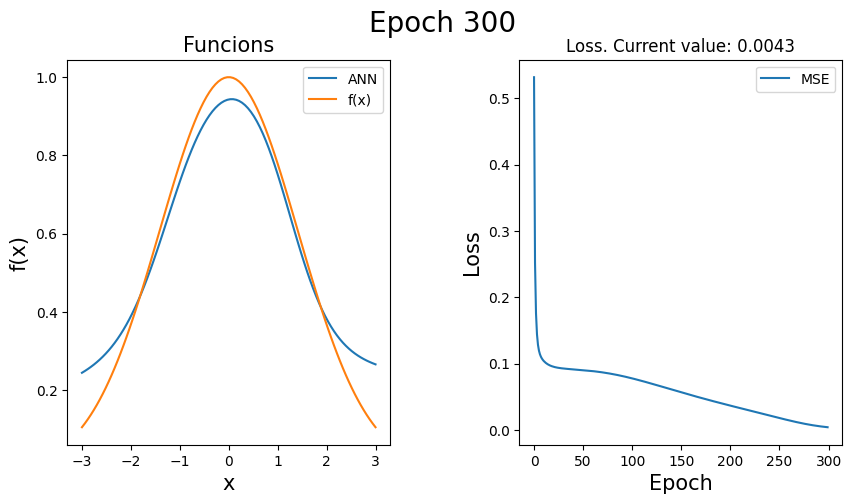

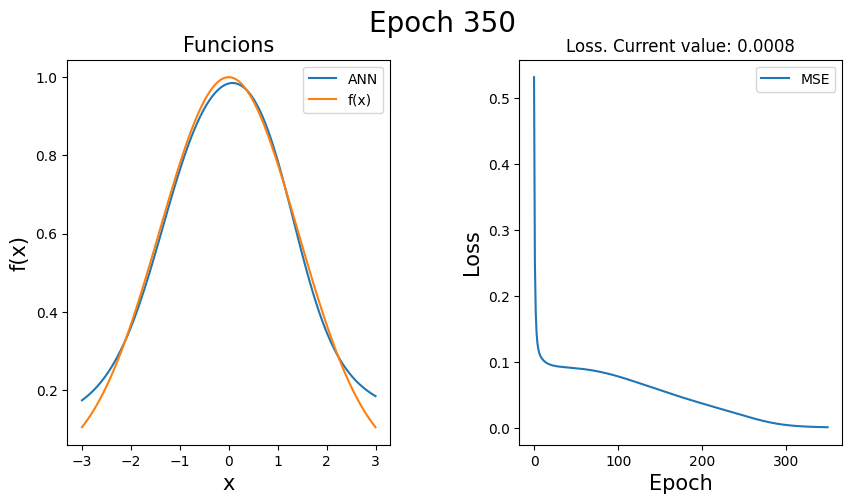

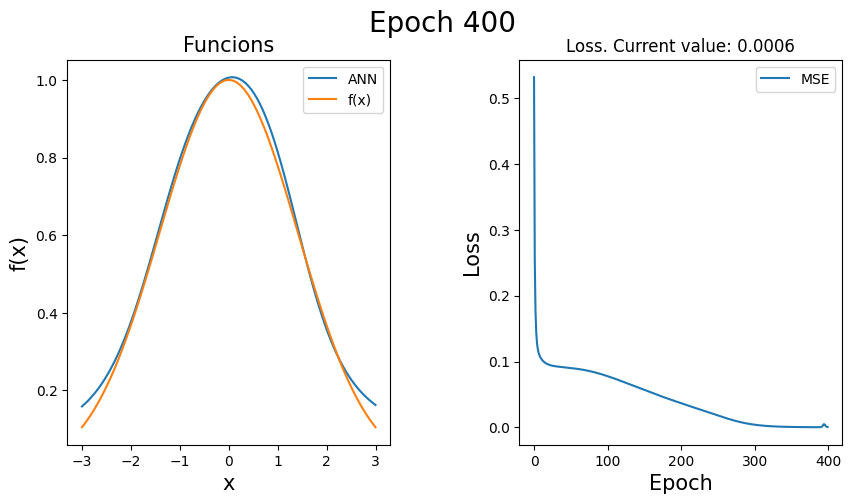

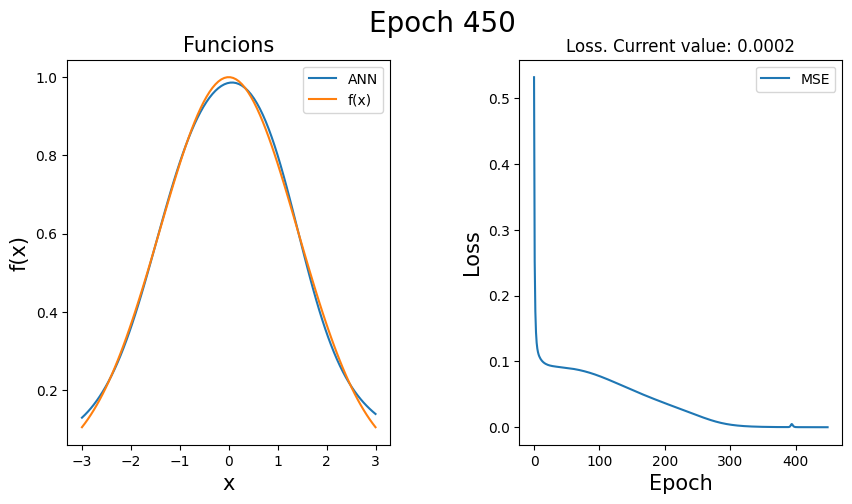

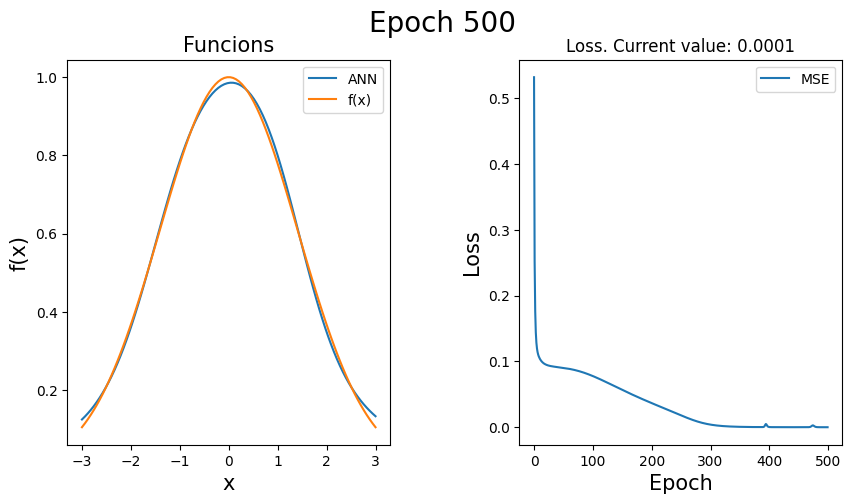

In [9]:
loss_list = [] # we accumulate the loss values here
target = target_function(train_set).to(device)

# Train loop
for t in range(epochs):
    pred = net(train_set) # prediction
    loss = loss_fn(pred, target) # we compute the loss
    loss_list.append(loss.item())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Plots
    if (t + 1) % 50 == 0 or t == epochs - 1:
        pic_creator(t, train_set, pred, target, loss_list)

## Test set
We have trained our model by repeatedly passing the same `x` coordinate points (train set), and we have plotted the predictions on this train set agains the exact ones. Now we must check whether our model also yields sensible predictions in other points, which is our ultimate goal. We must take into account that, when we use the `plot()` method of the `matplotlib.pyplot` module, Python will plot a continuous line even if we gave it a discrete set of points. This does **NOT** mean that the network predictions in some other points will be the ones suggested by the continuous line! In general, a more honest way to plot our results is with the method `scatter()`.

We now define a `test set` which we will pass to the same network that we have trained above. This is to see if the model predictions at these new points make any sense. We build the test set so that it contains points which are different to those in `train_set`: we include points outside of the interval $(-3, 3)$ and also points in between those used in that same interval in `train_set`.

In [10]:
test_set = torch.linspace(-5,  5, 79).view(-1, 1).to(device)

We now test the network in the new points.

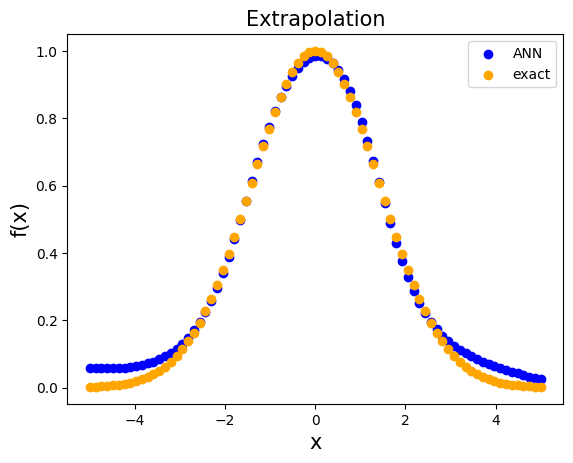

In [11]:
net.eval() # evaluation/inference mode
pred_between = net(test_set)

fig, ax = plt.subplots(nrows=1, ncols=1)
plt.subplots_adjust(wspace=0.4)

ax.set_title('Extrapolation', fontsize=15)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)
ax.scatter(test_set.cpu().numpy(), pred_between.cpu().detach().numpy(), color='blue', label='ANN')
ax.scatter(test_set.cpu().numpy(), target_function(test_set).cpu().numpy(), color='orange', label='exact')
ax.legend()

The net does not make good predictions outside of the training set! We must be careful when extrapolating/interpolating with a neural-network model.

## ChatGPT
Although not perfect, in practice ChatGPT could have generated all the code above in a few seconds if we ask correclty. For example, below we have the code it generated when we gave it the following instructions:

*In pytorch, code a one-input, one-output neural network and train it to learn the function f(x)=exp(-0.5x**2/2). Use 500 epochs, a learning rate of 0.01, RMSprop as the optimizer, and a training set of 100 points between -3 and 3.*

Epoch [50/500], Loss: 0.0011
Epoch [100/500], Loss: 0.0006
Epoch [150/500], Loss: 0.0006
Epoch [200/500], Loss: 0.0009
Epoch [250/500], Loss: 0.0010
Epoch [300/500], Loss: 0.0008
Epoch [350/500], Loss: 0.0008
Epoch [400/500], Loss: 0.0008
Epoch [450/500], Loss: 0.0011
Epoch [500/500], Loss: 0.0017


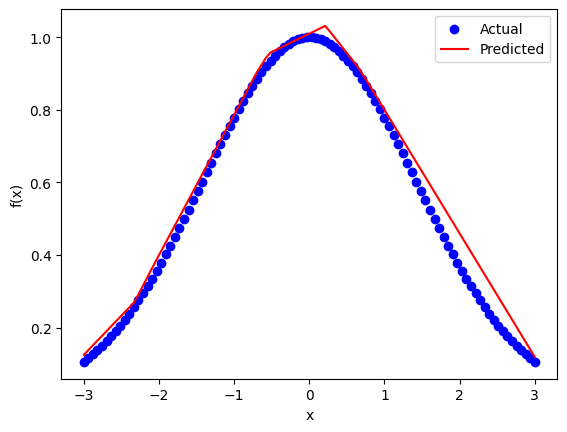

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create the training dataset
x_train = torch.linspace(-3, 3, 100).reshape(-1, 1)
y_train = torch.exp(-0.5 * x_train**2 / 2)

# Create an instance of the network
net = Net()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.01)

# Training loop
for epoch in range(500):
    # Forward pass
    outputs = net(x_train)
    loss = criterion(outputs, y_train)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss at every 50th epoch
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{500}], Loss: {loss.item():.4f}')

# Test the trained model
x_test = torch.linspace(-3, 3, 100).reshape(-1, 1)
y_pred = net(x_test)

# Plot the results
import matplotlib.pyplot as plt
plt.scatter(x_train.numpy(), y_train.numpy(), color='b', label='Actual')
plt.plot(x_test.numpy(), y_pred.detach().numpy(), color='r', label='Predicted')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()


It nailed this example because it is a simple exercise and there are hunders of similar examples online with which it was trained. However, when one wants to do more sophisticated things, it will often fail to produce the (a) right answer.